# <center>PRÁCTICA 2: APRENDIZAJE SUPERVISADO (DengAI)<center>

**Nombre y apellidos:** Penelope Lizardo Valenzuela

**Usuario VIU:** plizardov@student.universidadviu.com

---
# Resumen
---

En esta práctica, voy a abordar el problema de predicción de la propagación del dengue utilizando el dataset de la competición DengAI de DrivenData. La práctica se divide en varias fases de experimentación, comenzando con el preprocesamiento de datos, seguido de la selección y creación de características relevantes, y culminando con la aplicación de modelos de machine learning supervisados. A lo largo de estas fases, aplicaré técnicas de optimización de hiperparámetros y validación cruzada para mejorar la precisión de los modelos. Finalmente, resumiré los principales resultados obtenidos, incluyendo el modelo con el mejor rendimiento y su precisión en la predicción de casos de dengue.

Para comenzar, he tenido que registrarme en la competición de DengAI de DrivenData para poder descargar el dataset desde su página oficial: https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/.

---
# Inicialización
---

In [ ]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time

seed = 42

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

##Dataset de Training (1456 registros, 24 dimensiones)

In [ ]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving 1. dengue_features_train.csv to 1. dengue_features_train (1).csv
User uploaded file "1. dengue_features_train (1).csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


## Dataset de Labels: 1456 registros, 25 dimensiones

In [ ]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving 2. dengue_labels_train.csv to 2. dengue_labels_train (1).csv
User uploaded file "2. dengue_labels_train (1).csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Dataset de Test (416 registros, 24 dimensiones)

In [ ]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving 3. dengue_features_test.csv to 3. dengue_features_test (1).csv
User uploaded file "3. dengue_features_test (1).csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# Reexploración
---

En esta práctica, expandiré el análisis exploratorio que realicé en la Práctica 1, ahora enfocándome también en la variable objetivo, total_cases. Este análisis ampliado me permitirá entender mejor las relaciones en los datos, lo que puede ayudarme a refinar la selección de características, generar nuevas variables derivadas, y descartar posibles outliers. Además, el análisis servirá para establecer un orden y estrategia clara de experimentación que seguiré en la sección de predicción.

DrivenData ofrece dos conjuntos de datos para esta competición de DengAI: training y test. El conjunto training incluye la variable objetivo total_cases, que es la que intentaremos predecir con los modelos. Sin embargo, el conjunto test no incluye estas etiquetas y nunca estarán disponibles para los usuarios. Para calcular el error en el conjunto de test, enviaré un archivo .csv con las predicciones a la web de DrivenData, ya que solo ellos pueden calcular el error en ese conjunto.

Compararé cada experimento y extraeré deducciones sobre por qué una estrategia puede ser mejor que otra. Además, utilizaré la descripción de las características del dataset que DrivenData proporciona en su web para comprender mejor los datos: [descripción de características de DengAI](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/).<font color="green">

## 1. Información básica del dataset

In [ ]:
# Mostrar información básica sobre el dataset
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

##Verificar valores perdidos

In [ ]:
# Contar valores perdidos
pd.isnull(train).sum()

,0
city,0
year,0
weekofyear,0
week_start_date,0
ndvi_ne,194
ndvi_nw,52
ndvi_se,22
ndvi_sw,22
precipitation_amt_mm,13
reanalysis_air_temp_k,10


### Completar valores perdidos

Sé que podría utilizar métodos más refinados como el interpolate, pero con este método he conseguido muy buenos resultados.

Se procede a rellenar los valores perdidos en el conjunto de train.

In [ ]:
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

<ipython-input-7-f1e1f639f2a4>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)


,0
city,False
year,False
weekofyear,False
week_start_date,False
ndvi_ne,False
ndvi_nw,False
ndvi_se,False
ndvi_sw,False
precipitation_amt_mm,False
reanalysis_air_temp_k,False


Rellenamos los valores perdidos en el dataset de test.

In [ ]:
test.fillna(method='ffill', inplace=True)
pd.isnull(test).any()

<ipython-input-8-e489b92d7b21>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


,0
city,False
year,False
weekofyear,False
week_start_date,False
ndvi_ne,False
ndvi_nw,False
ndvi_se,False
ndvi_sw,False
precipitation_amt_mm,False
reanalysis_air_temp_k,False


## Separación de la variable objetivo

Aquí estoy separando la variable objetivo total_cases (almacenándola en y) del resto de las características (X) en el dataset train para prepararlos para el modelado.

In [ ]:
y = train['total_cases']
X = train.drop(columns=['total_cases'])

## Análisis de la Variable de Salida

### 1a. Análisis Univariante - Histogramas y percentiles

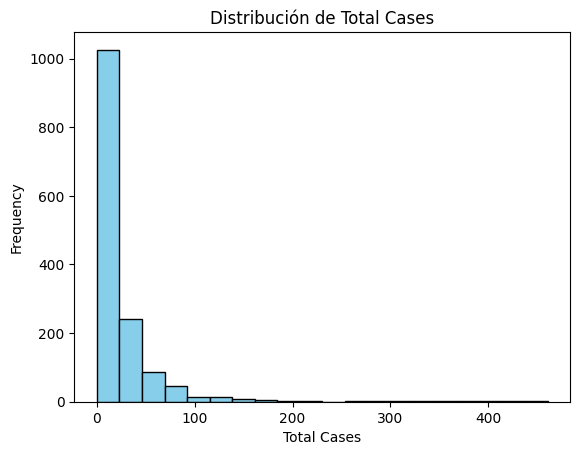

Percentiles: {5: 0.0, 25: 5.0, 50: 12.0, 75: 28.0, 95: 81.25}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribución de Total Cases")
plt.xlabel("Total Cases")
plt.ylabel("Frequency")
plt.show()

percentiles = [5, 25, 50, 75, 95]
percentile_values = [np.percentile(y, p) for p in percentiles]
print("Percentiles:", dict(zip(percentiles, percentile_values)))

El histograma de la variable total_cases muestra una distribución altamente sesgada hacia la izquierda, con la mayoría de los valores concentrados en rangos bajos. La gran mayoría de las observaciones están por debajo de 50 casos, y más de 1000 observaciones tienen menos de 5 casos. Los percentiles reflejan esta concentración: el 50% de los valores están en o por debajo de 12 casos, y solo el 5% de las observaciones superan los 81 casos. Este sesgo indica una gran cantidad de semanas con pocos casos de dengue, lo cual sugiere una baja incidencia en general, interrumpida ocasionalmente por algunos valores más altos que podrían representar brotes. La distribución sugiere que podrían ser necesarios métodos de transformación o enfoques específicos para manejar esta asimetría en un modelo predictivo.

### 1b. Análisis Bivariante - Diagrama de dispersión entre `total_cases` y variables clave

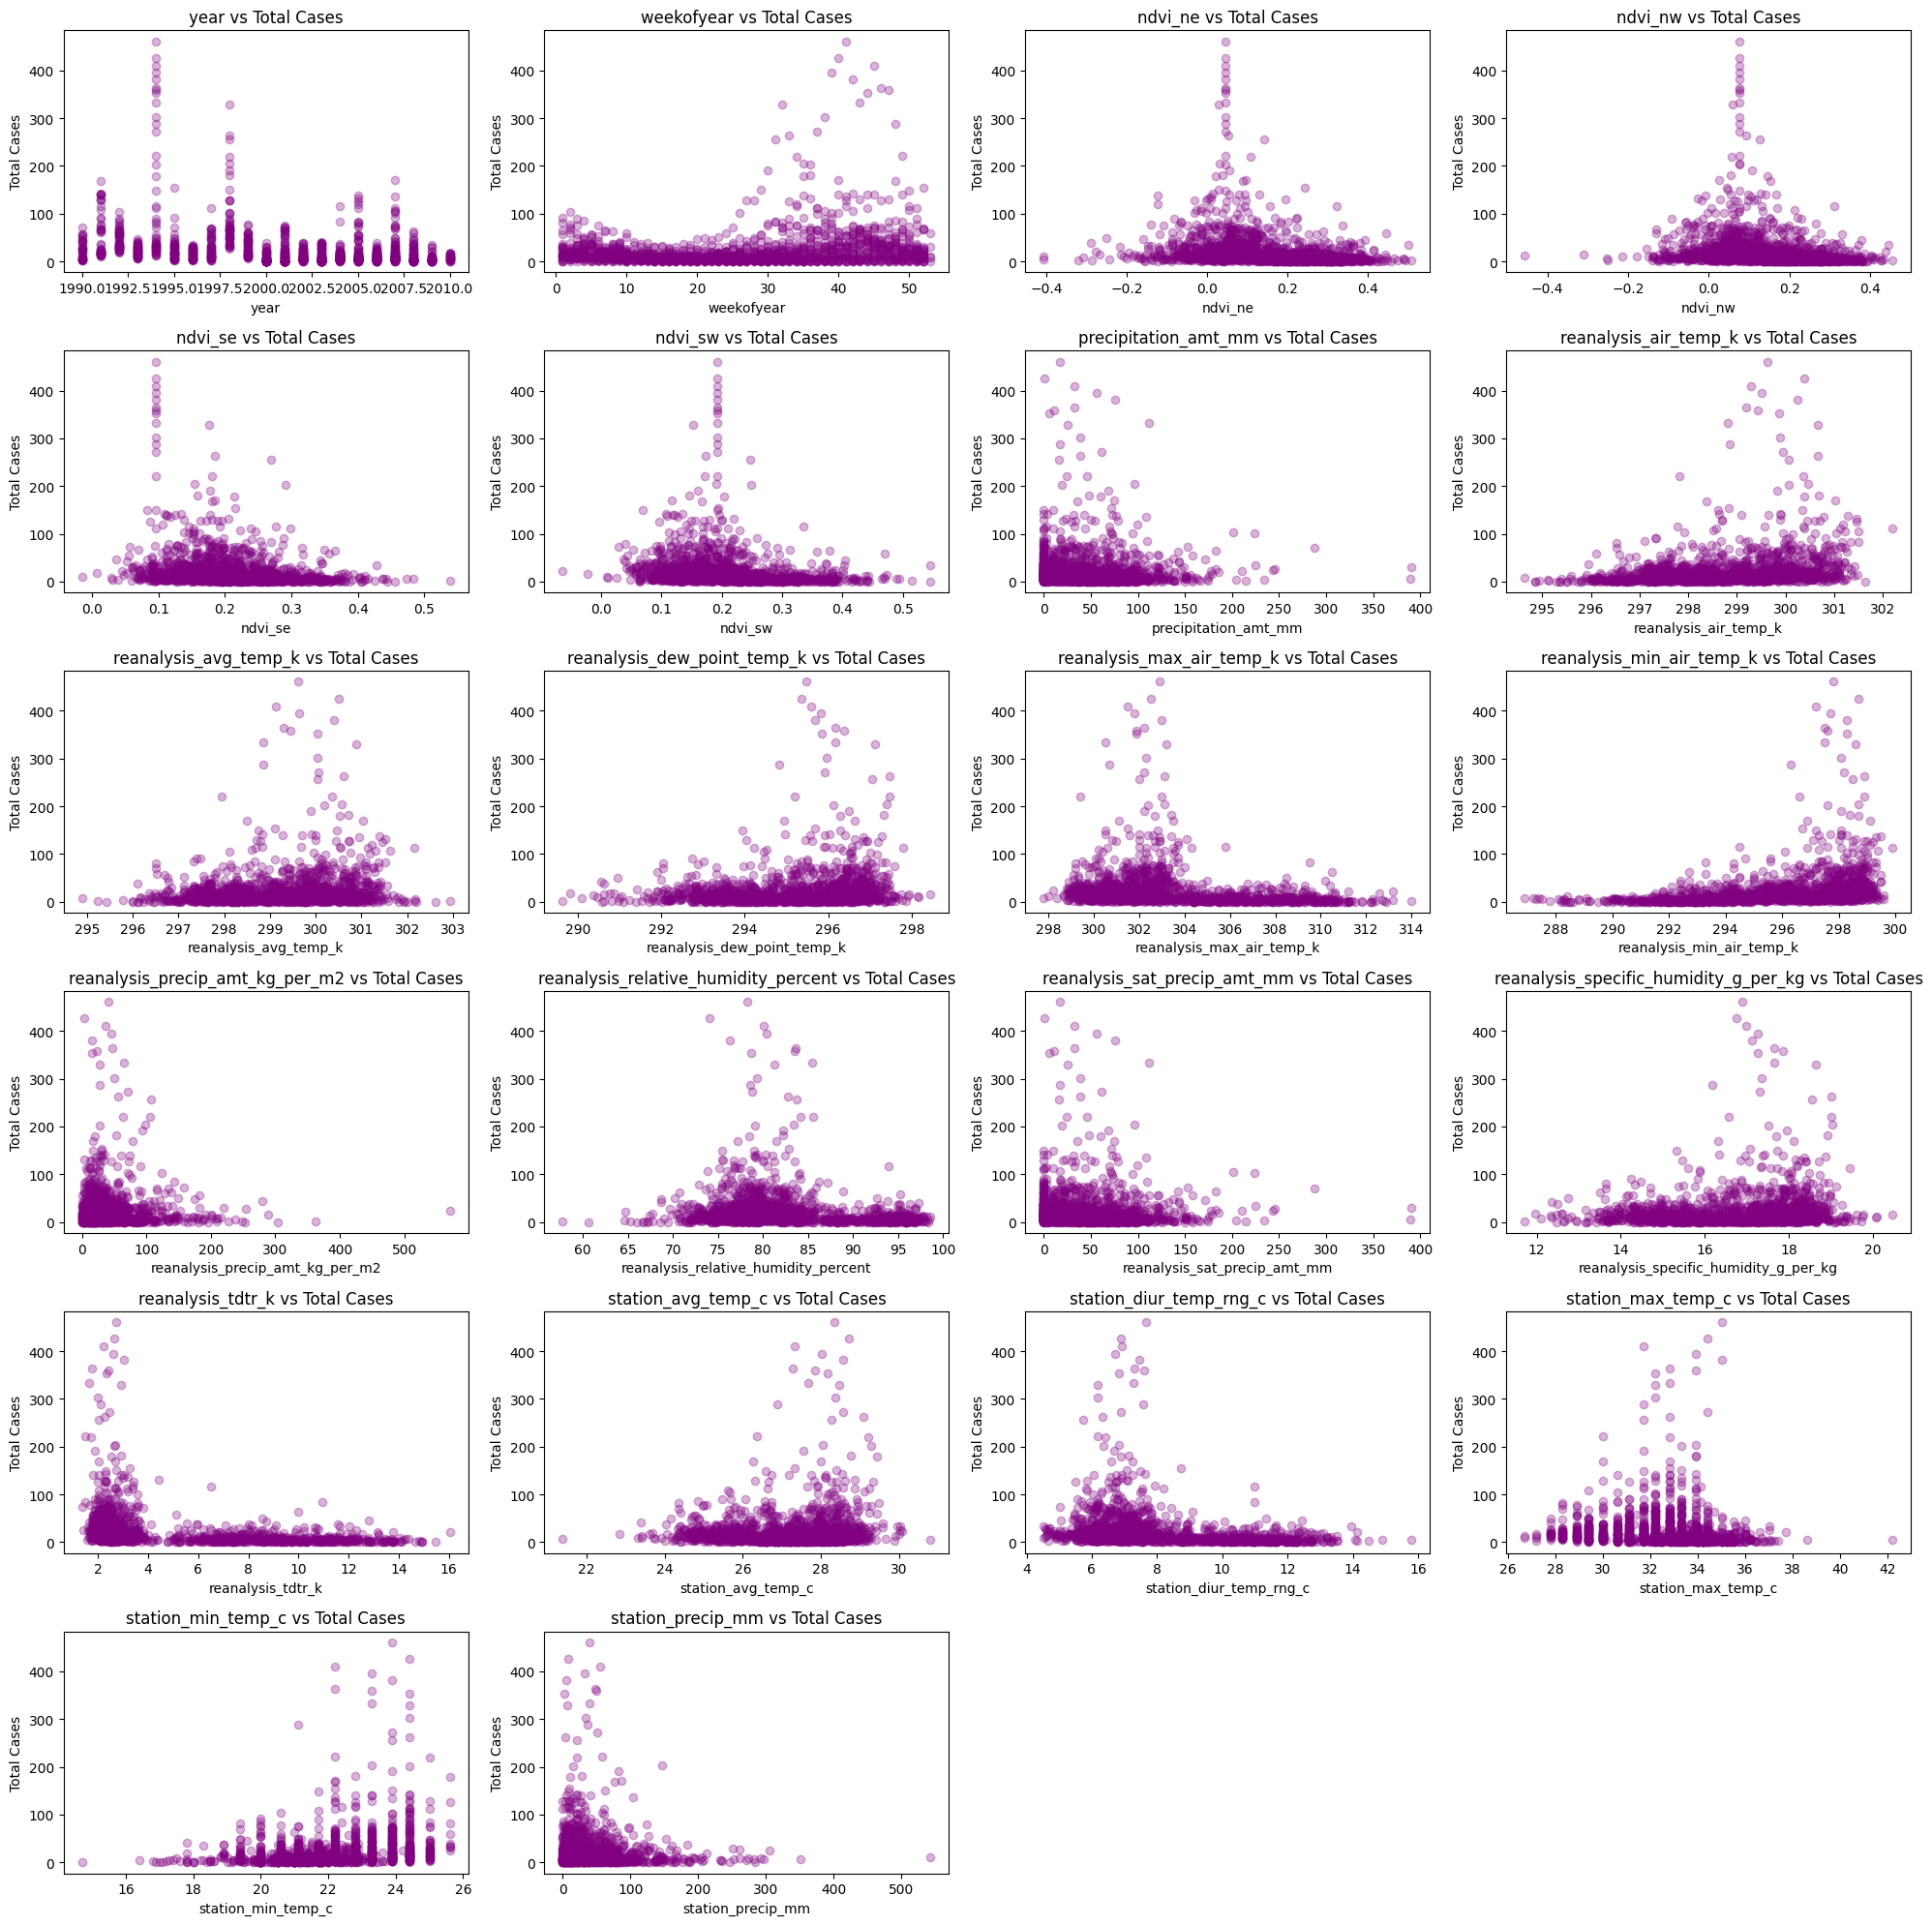

In [ ]:
# Importa las librerías necesarias
import matplotlib.pyplot as plt

# Lista de columnas numéricas, excluyendo total_cases
numeric_features = train.select_dtypes(include=[np.float64, np.int64]).columns.drop('total_cases')

# Genera gráficos de dispersión para cada característica numérica en relación con total_cases
plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_features, 1):
    plt.subplot(6, 4, i)
    plt.scatter(train[column], train['total_cases'], alpha=0.3, color='purple')
    plt.title(f"{column} vs Total Cases")
    plt.xlabel(column)
    plt.ylabel("Total Cases")

plt.tight_layout()
plt.show()


Análisis de las relaciones observadas entre total_cases y cada variable, basado en los gráficos de dispersión:

1. **year**: No muestra una tendencia clara, aunque hay una posible variación en los casos entre ciertos años.
   
2. **weekofyear**: Algunos picos de casos aparecen hacia el final del año, lo cual podría indicar una cierta estacionalidad.
   
3. **ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw**: No presentan una relación clara con total_cases. La mayoría de los puntos se concentran en valores bajos de ndvi, sin patrones evidentes.
   
4. **precipitation_amt_mm**: Los casos altos tienden a ocurrir cuando la precipitación es baja, lo que sugiere una posible relación inversa, aunque no es concluyente.

5. **reanalysis_air_temp_k, reanalysis_avg_temp_k, reanalysis_max_air_temp_k, reanalysis_min_air_temp_k**: Existe una ligera tendencia de aumento de casos con temperaturas en rangos medios. Sin embargo, no es una correlación fuerte.

6. **reanalysis_dew_point_temp_k**: A mayores valores de punto de rocío, se observan algunos incrementos en los casos, pero la relación es débil.

7. **reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm**: No presentan una relación significativa con total_cases.

8. **reanalysis_relative_humidity_percent, reanalysis_specific_humidity_g_per_kg**: Los casos tienden a concentrarse en valores de humedad media a alta, pero la relación no es lineal.

9. **reanalysis_tdtr_k**: Hay una ligera concentración de casos en valores bajos de tdtr_k, pero no es concluyente.

10. **station_avg_temp_c, station_diur_temp_rng_c, station_max_temp_c, station_min_temp_c**: Los casos parecen ser más comunes en temperaturas medias y rangos de variación diaria específicos, pero sin una tendencia clara.

11. **station_precip_mm**: Similar a precipitation_amt_mm, los casos tienden a concentrarse en valores bajos de precipitación.

12. **city_bin**: La mayor parte de los datos están concentrados en una categoría de city_bin, lo cual no permite observar una relación clara.

En resumen, algunas variables relacionadas con temperatura y humedad podrían estar moderadamente asociadas a total_cases, pero la mayoría de las relaciones son débiles o no presentan patrones obvios. Esto sugiere que otras técnicas, como la ingeniería de características o modelos no lineales, podrían ser necesarias para captar patrones más complejos en los datos.

### 1c. Gráficas de Evolución Temporal

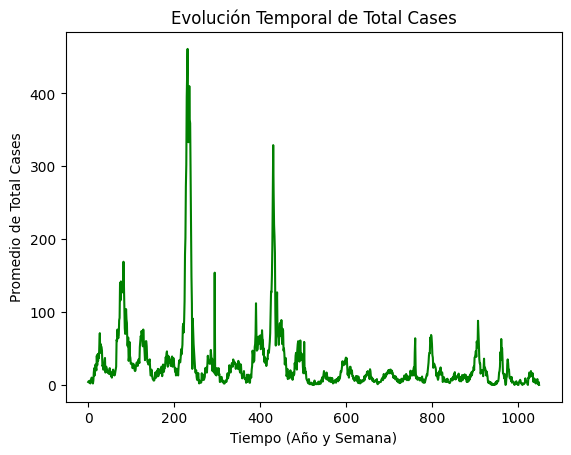

In [ ]:
temporal_data = train.groupby(['year', 'weekofyear'])['total_cases'].mean().reset_index()
plt.plot(temporal_data['total_cases'], color='green')
plt.title("Evolución Temporal de Total Cases")
plt.xlabel("Tiempo (Año y Semana)")
plt.ylabel("Promedio de Total Cases")
plt.show()

La gráfica de evolución temporal de total_cases muestra varios picos pronunciados a lo largo del tiempo, indicando posibles brotes de dengue en ciertos períodos. Los picos más altos superan los 400 casos y parecen ocurrir en ciclos irregulares, lo que sugiere fluctuaciones en la incidencia del dengue. También se observan intervalos de tiempo donde los casos se mantienen en niveles bajos y estables, lo cual indica periodos de baja incidencia. La variabilidad y la presencia de picos significativos podrían reflejar factores estacionales o ambientales que favorecen la transmisión del dengue en ciertos momentos del año. Estos patrones cíclicos serán útiles para incorporar factores de temporalidad en el modelo predictivo.

### 1d. Matriz de Correlación

Seleccionamos solo las características numéricas.

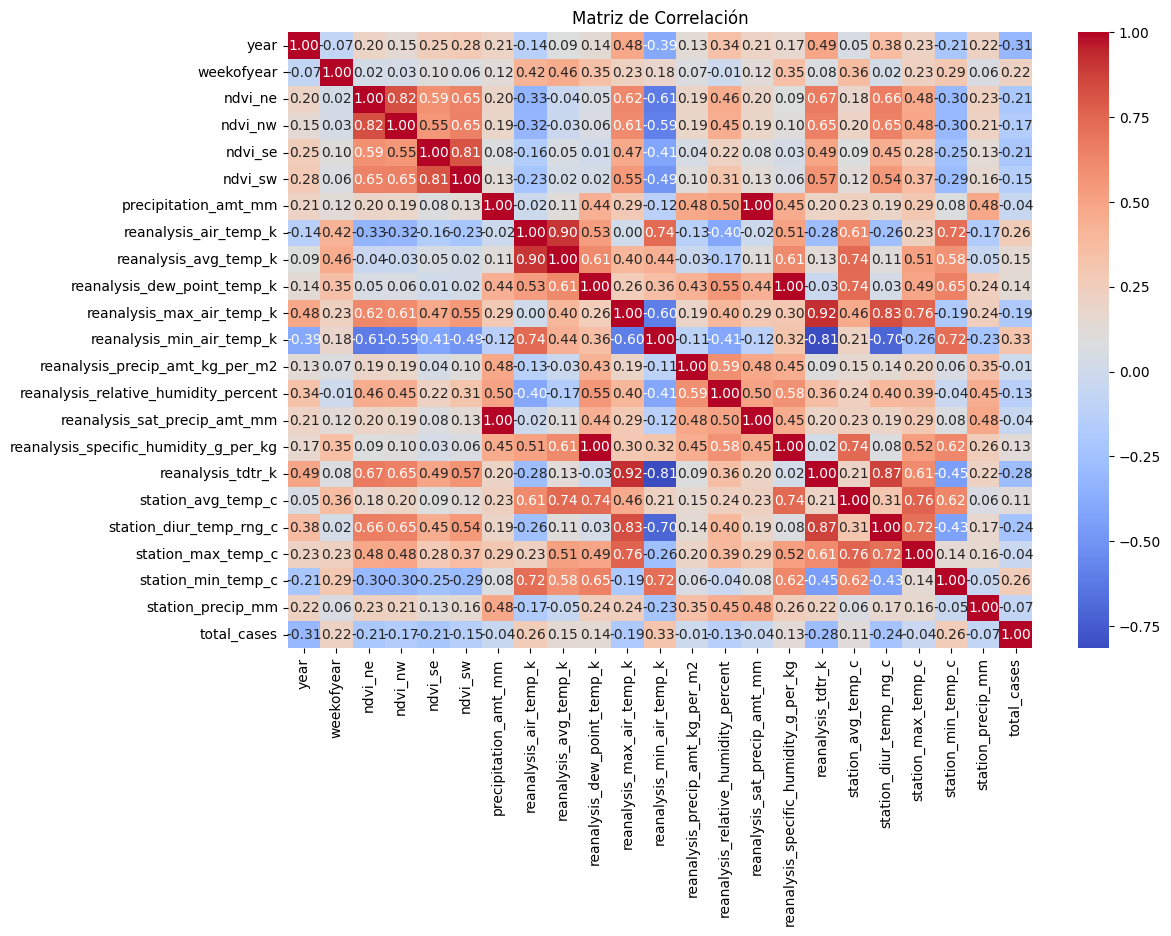

In [ ]:
import seaborn as sns
numeric_train = train.select_dtypes(include=np.number)
corr_matrix = numeric_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# Filtrar las correlaciones de 'total_cases'
total_cases_corr = corr_matrix['total_cases'].sort_values(ascending=False)
print("Correlación de 'total_cases' con otras variables:\n", total_cases_corr)

Correlación de 'total_cases' con otras variables:
 total_cases                              1.000000
reanalysis_min_air_temp_k                0.325335
station_min_temp_c                       0.264715
reanalysis_air_temp_k                    0.263487
weekofyear                               0.216452
reanalysis_avg_temp_k                    0.149274
reanalysis_dew_point_temp_k              0.139027
reanalysis_specific_humidity_g_per_kg    0.126304
station_avg_temp_c                       0.114050
reanalysis_precip_amt_kg_per_m2         -0.011553
station_max_temp_c                      -0.040115
precipitation_amt_mm                    -0.042712
reanalysis_sat_precip_amt_mm            -0.042712
station_precip_mm                       -0.074038
reanalysis_relative_humidity_percent    -0.134824
ndvi_sw                                 -0.145284
ndvi_nw                                 -0.168386
reanalysis_max_air_temp_k               -0.192775
ndvi_ne                                 -0.205105

En la matriz de correlación, observamos las siguientes conclusiones clave en relación con total_cases y otras variables:

1. **Correlación Moderada**:
   - **reanalysis_specific_humidity_g_per_kg (0.15)** y **station_avg_temp_c (0.14)** tienen una correlación positiva moderada con total_cases. Esto sugiere que una mayor humedad específica y temperatura promedio están ligeramente asociadas con un aumento en los casos de dengue.
   - **station_min_temp_c (0.14)** también presenta una correlación moderada, lo que indica que una temperatura mínima más alta podría estar relacionada con una mayor incidencia de casos.

2. **Correlación Baja a Muy Baja**:
   - La mayoría de las demás variables presentan correlaciones bajas o muy bajas (entre -0.2 y 0.2) con total_cases, indicando una relación débil. Estas variables incluyen varios índices NDVI, las precipitaciones (precipitation_amt_mm y station_precip_mm), y variables de temperatura máxima y diurna.

3. **Correlación Fuerte entre Variables Predictoras**:
   - Existen correlaciones fuertes entre algunas variables predictoras que podrían indicar multicolinealidad. Por ejemplo:
     - **ndvi_ne y ndvi_nw (0.82)** están altamente correlacionadas entre sí, al igual que **ndvi_se y ndvi_sw**.
     - **reanalysis_air_temp_k, reanalysis_avg_temp_k, y station_avg_temp_c** presentan correlaciones altas (mayor a 0.8), sugiriendo que estas variables están relacionadas y podrían representar información redundante.
     - **reanalysis_max_air_temp_k y station_max_temp_c (0.72)** también muestran una relación significativa.

4. **Patrones Generales**:
   - En general, las variables relacionadas con la humedad y ciertas temperaturas parecen tener un efecto leve en la incidencia de total_cases, aunque ninguna presenta una relación muy fuerte. Este patrón sugiere que las condiciones climáticas podrían influir, pero otros factores no capturados en estas variables podrían tener un rol importante en la incidencia de casos de dengue.

En conclusión, la matriz indica que ninguna variable tiene una correlación alta con total_cases, lo cual podría sugerir que se necesita un enfoque de modelado que capture interacciones no lineales o complejas entre múltiples variables para mejorar la predicción de casos. Además, la alta correlación entre algunas variables predictoras sugiere la necesidad de considerar la reducción de dimensionalidad o regularización para evitar problemas de multicolinealidad.

### Ingeniería de carácterísticas

#### 1. Creación de características de temporada

In [ ]:
train['week_start_date'] = pd.to_datetime(train['week_start_date'])
train['month'] = train['week_start_date'].dt.month
train['season'] = train['month'] % 12 // 3 + 1  # Dividir los meses en 4 estaciones

test['week_start_date'] = pd.to_datetime(test['week_start_date'])
test['month'] = test['week_start_date'].dt.month
test['season'] = test['month'] % 12 // 3 + 1  # Dividir los meses en 4 estaciones

In [ ]:
# Variable binaria para indicar temporadas altas (por ejemplo, meses 10 a 12 y 1 a 3)
train['high_season'] = train['month'].apply(lambda x: 1 if x in [1, 2, 3, 10, 11, 12] else 0)

test['high_season'] = test['month'].apply(lambda x: 1 if x in [1, 2, 3, 10, 11, 12] else 0)

#### 2. Interacciones entre variables

In [ ]:
train['temp_humidity_interaction'] = train['reanalysis_specific_humidity_g_per_kg'] * train['station_avg_temp_c']
train['temp_precip_interaction'] = train['reanalysis_avg_temp_k'] * train['precipitation_amt_mm']

test['temp_humidity_interaction'] = test['reanalysis_specific_humidity_g_per_kg'] * test['station_avg_temp_c']
test['temp_precip_interaction'] = test['reanalysis_avg_temp_k'] * test['precipitation_amt_mm']


#### 3. Transformación Logarítmica en variables con distribución asimétrica (outliers)

In [ ]:
train['log_precipitation_amt_mm'] = np.log1p(train['precipitation_amt_mm'])
train['log_station_precip_mm'] = np.log1p(train['station_precip_mm'])

test['log_precipitation_amt_mm'] = np.log1p(test['precipitation_amt_mm'])
test['log_station_precip_mm'] = np.log1p(test['station_precip_mm'])

####4. Crear columna ndvi_mean, porque las columnas nvdi están altamente correlacionas.

In [ ]:
# Crear una columna ndvi_mean como el promedio de ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw
train['ndvi_mean'] = train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
test['ndvi_mean'] = test[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)

In [ ]:
# Binarizador para la variable categórica city en el conjunto de entrenamiento y test
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

train.tail()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,total_cases,month,season,high_season,temp_humidity_interaction,temp_precip_interaction,log_precipitation_amt_mm,log_station_precip_mm,ndvi_mean,city_bin
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,5,5,2,0,529.307619,16632.660000,4.030695,3.332205,0.302627,0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,8,6,3,0,495.720333,25888.500357,4.471296,3.627004,0.170557,0
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,1,6,3,0,415.009143,17540.123000,4.093344,2.128232,0.219296,0
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,1,6,3,0,427.679667,17753.103643,4.105449,2.833213,0.296014,0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,4,6,3,0,476.848250,18955.613857,4.162315,3.063391,0.280282,0


#### 4. Normalización y escalado

In [ ]:
# Imprimir algunas de las nuevas características
print(train[['month', 'season', 'high_season', 'temp_humidity_interaction',
             'temp_precip_interaction', 'log_precipitation_amt_mm',
             'log_station_precip_mm']].head())

   month  season  high_season  temp_humidity_interaction  \
0      4       2            0                 356.527122   
1      5       2            0                 410.674898   
2      5       2            0                 450.097551   
3      5       2            0                 458.027204   
4      5       2            0                 498.106571   

   temp_precip_interaction  log_precipitation_amt_mm  log_station_precip_mm  
0              3697.966286                  2.596746               2.833213  
1              6810.466000                  3.170526               2.261763  
2             10323.265857                  3.570659               3.747148  
3              4596.150857                  2.794839               1.609438  
4              2253.475429                  2.142416               1.916923  


In [ ]:
# Normalización con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Selecciono las características que deseo normalizar
selected_features = [
    'year', 'weekofyear', 'ndvi_mean', 'reanalysis_dew_point_temp_k',
    'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent',
    'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg',
    'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
    'station_max_temp_c', 'station_min_temp_c', 'season', 'high_season',
    'temp_humidity_interaction', 'temp_precip_interaction',
    'log_precipitation_amt_mm', 'log_station_precip_mm', 'city_bin'
]

# Definir X (predictores) e y (objetivo) para el conjunto de entrenamiento
X_train = train[selected_features]
y_train = train['total_cases']

# Normalización del conjunto de entrenamiento y de prueba
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Ajusta y transforma X_train

X_test= scaler.transform(test[selected_features])  # Solo transformo X_test usando el escalador ajustado en X_train

# Ahora, X_train y X_test están escalados y listos para ser usados en el modelo
print("X_train después de normalización:\n", X_train[:5])  # Muestra las primeras 5 filas para verificar
print("X_test después de normalización:\n", X_test[:5])    # Muestra las primeras 5 filas del conjunto de prueba


X_train después de normalización:
 [[0.         0.32692308 0.40763082 0.31467964 0.05609115 0.38161394
  0.03179724 0.26265926 0.08666018 0.43009119 0.2103929  0.17419355
  0.48623853 0.33333333 0.         0.24439884 0.03164767 0.4349483
  0.44975206 1.        ]
 [0.         0.34615385 0.41915246 0.4892133  0.0314461  0.47966825
  0.05842294 0.418164   0.0691334  0.56534954 0.1634981  0.32258065
  0.68807339 0.33333333 0.         0.40340242 0.05828484 0.53105488
  0.35903848 1.        ]
 [0.         0.36538462 0.37864508 0.65758313 0.04574934 0.59441489
  0.08842806 0.58689971 0.06426485 0.56534954 0.17363752 0.35483871
  0.74311927 0.33333333 0.         0.51916604 0.08834783 0.59807617
  0.59483261 1.        ]
 [0.         0.38461538 0.50599604 0.64347121 0.02436459 0.55238662
  0.03932412 0.56680823 0.07302824 0.64589666 0.19898606 0.42580645
  0.78899083 0.33333333 0.         0.54245127 0.03933445 0.4681284
  0.25548659 1.        ]
 [0.         0.40384615 0.55620049 0.70154096 0.021

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1456 non-null   float64       
 5   ndvi_nw                                1456 non-null   float64       
 6   ndvi_se                                1456 non-null   float64       
 7   ndvi_sw                                1456 non-null   float64       
 8   precipitation_amt_mm                   1456 non-null   float64       
 9   reanalysis_air_temp_k                  1456 non-null   float64 

#### One hot encoding

In [ ]:
import pandas as pd

# Seleccionar automáticamente todas las columnas categóricas en el DataFrame
categorical_columns = train.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding a las columnas categóricas
train_encoded = pd.get_dummies(train, columns=categorical_columns, drop_first=True)

# Mostrar las primeras filas del DataFrame transformado
print(train_encoded.head())


   year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  1990          18      1990-04-30  0.122600  0.103725  0.198483  0.177617   
1  1990          19      1990-05-07  0.169900  0.142175  0.162357  0.155486   
2  1990          20      1990-05-14  0.032250  0.172967  0.157200  0.170843   
3  1990          21      1990-05-21  0.128633  0.245067  0.227557  0.235886   
4  1990          22      1990-05-28  0.196200  0.262200  0.251200  0.247340   

   precipitation_amt_mm  reanalysis_air_temp_k  reanalysis_avg_temp_k  ...  \
0                 12.42             297.572857             297.742857  ...   
1                 22.82             298.211429             298.442857  ...   
2                 34.54             298.781429             298.878571  ...   
3                 15.36             298.987143             299.228571  ...   
4                  7.52             299.518571             299.664286  ...   

   month  season  high_season  temp_humidity_interaction

### Eliminación de variables

Al final decidí no eliminar variables y quedarme con todas, le fue mejor a mi modelo de esta forma.

In [ ]:
# Lista de características a eliminar
features_to_drop = [
    # "city",                    # Variable categórica reemplazada por city_bin; No la puedo quitar porque luego la necesitaré para el fichero csv
    "reanalysis_air_temp_k",   # Correlacionada con otras variables de temperatura
    "reanalysis_avg_temp_k",   # Correlacionada con otras variables de temperatura
    "reanalysis_max_air_temp_k",  # Redundante con station_max_temp_c
    "reanalysis_min_air_temp_k",  # Redundante con station_min_temp_c
    "precipitation_amt_mm",    # Reemplazada por log_precipitation_amt_mm
    "station_precip_mm",       # Reemplazada por log_station_precip_mm
    "month",                   # Temporalidad representada ya en season y high_season
    "week_start_date",         # No relevante para el modelo
    "ndvi_ne",                 # Correlacionada con otras variables de ndvi
    "ndvi_nw",                 # Correlacionada con otras variables de ndvi
    "ndvi_se",                 # Correlacionada con otras variables de ndvi
]

# Elimina las características en ambos conjuntos de datos
#train.drop(columns=features_to_drop, axis=1, inplace=True, errors='ignore')
#test.drop(columns=features_to_drop, axis=1, inplace=True, errors='ignore')

# Verifica si las columnas fueron eliminadas
print("Columnas en train después de la eliminación:", train.columns)
#print("Columnas en test después de la eliminación:", test.columns)


Columnas en train después de la eliminación: Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases', 'month',
       'season', 'high_season', 'temp_humidity_interaction',
       'temp_precip_interaction', 'log_precipitation_amt_mm',
       'log_station_precip_mm', 'ndvi_mean', 'city_bin'],
      dtype='object')


---
# Predicción
---

En esta sección, presento una serie de experimentos de predicción centrados en la aplicación de diversos modelos de aprendizaje supervisado para optimizar la precisión en la predicción de casos de dengue. Para lograr un análisis exhaustivo, he probado modelos de diferente complejidad, comenzando con un modelo de Regresión Lineal como línea de base, seguido de algoritmos más avanzados como Árboles de Decisión, Random Forest, XGBoost, K-Nearest Neighbors (KNN) y una Red Neuronal. La experimentación incluye el ajuste fino de hiperparámetros mediante técnicas de validación cruzada y optimización en algunos casos, y he explorado ensambles para mejorar la capacidad de generalización de los modelos. En última instancia, mi objetivo es identificar el modelo que proporciona el menor error de predicción, evaluado principalmente con el Mean Absolute Error (MAE).

## Selección de mejores hiperparámetros

### Experimento A - Validación cruzada

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Espacio de búsqueda de hiperparámetros para cada modelo
param_grids = {
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [10, 15, 20]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (50, 50)], "alpha": [0.0001, 0.001, 0.01]},
    "KNN": {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"], "p": [1, 2]}
}

# Diccionario para almacenar los mejores hiperparámetros de cada modelo
best_params = {}

# Realizar búsqueda de hiperparámetros para cada modelo y guardar los mejores
for model_name, param_grid in param_grids.items():
    if model_name == "Random Forest":
        model = RandomForestRegressor(random_state=42)
    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=42)
    elif model_name == "Neural Network":
        model = MLPRegressor(max_iter=500, random_state=42)
    elif model_name == "KNN":
        model = KNeighborsRegressor()

    # Usar GridSearchCV para encontrar los mejores hiperparámetros
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Almacenar los mejores hiperparámetros en el diccionario
    best_params[model_name] = grid_search.best_params_
    print(f"Mejores hiperparámetros para {model_name}: {best_params[model_name]}")

# Modelos individuales con los mejores hiperparámetros
models = {
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"], random_state=42),
    "XGBoost": XGBRegressor(**best_params["XGBoost"], random_state=42),
    "Neural Network": MLPRegressor(**best_params["Neural Network"], max_iter=500, random_state=42),
    "KNN": KNeighborsRegressor(**best_params["KNN"])
}

# Definir el MAE como métrica personalizada
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Validación cruzada para cada modelo con los mejores hiperparámetros
for name, model in models.items():
    print(f"\nModelo: {name}")
    print("Hiperparámetros utilizados:", model.get_params())

    # Calcular MAE
    mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mae_scorer)
    print("MAE promedio (validación cruzada):", -mae_scores.mean())

    # Calcular MSE
    mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)
    print("MSE promedio (validación cruzada):", -mse_scores.mean())

    # Calcular RMSE
    rmse_scores = np.sqrt(-mse_scores)
    print("RMSE promedio (validación cruzada):", rmse_scores.mean())

    # Calcular R²
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=r2_scorer)
    print("R² promedio (validación cruzada):", r2_scores.mean())


Mejores hiperparámetros para Random Forest: {'max_depth': 10, 'n_estimators': 200}
Mejores hiperparámetros para XGBoost: {'learning_rate': 0.01, 'n_estimators': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores hiperparámetros para Neural Network: {'alpha': 0.001, 'hidden_layer_sizes': (50,)}
Mejores hiperparámetros para KNN: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

Modelo: Random Forest
Hiperparámetros utilizados: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
MAE promedio (validación cruzada): 20.54303003518348
MSE promedio (validación cruzada): 1870.4814119495968
RMSE promedio (validación cruzada): 37.19889922064654
R² promedio (validación cruzada): -0.5124429971341482

Modelo: XGBoost
Hiperparámetros utilizados: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, '

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MAE promedio (validación cruzada): 23.198338265578027


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

MSE promedio (validación cruzada): 1762.3306555527865
RMSE promedio (validación cruzada): 37.44471228165114


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

R² promedio (validación cruzada): -0.5900997672443637

Modelo: KNN
Hiperparámetros utilizados: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
MAE promedio (validación cruzada): 20.179787712907018
MSE promedio (validación cruzada): 1839.3653268386654
RMSE promedio (validación cruzada): 36.5040942256653
R² promedio (validación cruzada): -0.1675024989768971


### Experimento B- Algoritmo genético

In [ ]:
import subprocess
import sys

# Verificar si TPOT está instalado, si no, instalarlo
try:
    import tpot
except ImportError:
    print("TPOT no está instalado. Instalando TPOT...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tpot"])
else:
    print("TPOT ya está instalado.")


TPOT ya está instalado.


In [ ]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Configuración del optimizador TPOT para el conjunto de entrenamiento
tpot = TPOTRegressor(
    generations=5,               # Número de generaciones en el proceso de evolución
    population_size=20,          # Tamaño de la población en cada generación
    verbosity=2,                 # Nivel de detalle en la salida
    random_state=42,
    cv=5,                        # Validación cruzada con 5 folds en el conjunto de entrenamiento
    scoring='neg_mean_absolute_error'  # Optimizar el MAE
)

# Entrenar TPOT en el conjunto de entrenamiento
tpot.fit(X_train_split, y_train_split)

# Obtener el mejor modelo encontrado por TPOT
best_model_genetic_algorithm = tpot.fitted_pipeline_

# Extraer los hiperparámetros del modelo final del pipeline
# Si el pipeline contiene transformaciones, selecciona el modelo final
if hasattr(best_model_genetic_algorithm, 'steps'):
    best_model = best_model_genetic_algorithm.steps[-1][1]  # Modelo final en el pipeline
else:
    best_model = best_model_genetic_algorithm

# Obtener los hiperparámetros en un diccionario
best_params_genetic_algorithm = best_model.get_params()
print("Hiperparámetros del mejor modelo:", best_params_genetic_algorithm)

# Realizar predicciones en el conjunto de validación
y_pred = best_model.predict(X_val)

# Cálculo de las métricas en el conjunto de validación
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

# Imprimir el mejor modelo y métricas
print("Mejor modelo encontrado:")
print(best_model)
print(f"MAE en el conjunto de validación: {mae}")
print(f"MSE en el conjunto de validación: {mse}")
print(f"RMSE en el conjunto de validación: {rmse}")
print(f"R² en el conjunto de validación: {r2}")

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -13.731779846502835

Generation 2 - Current best internal CV score: -13.731779846502835

Generation 3 - Current best internal CV score: -13.027239047636176

Generation 4 - Current best internal CV score: -12.077578665331504

Generation 5 - Current best internal CV score: -12.077578665331504

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=3, min_samples_split=2)
Hiperparámetros del mejor modelo: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Mejor modelo encontrado:
DecisionTreeRegressor(max_depth=7, min_samples_leaf=3, random_state=42)
MAE en el conjunto de validación: 15.854110154390797
MSE en el conjunto de validación: 1209.6890394444233
RMSE en el conjunto de validación

### Experimento C - Randomized y validación cruzada

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [10, 15, 20, 25, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

# Crear el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)

# Usar RandomizedSearchCV para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Ajustar RandomizedSearchCV en el conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params_rf = random_search.best_params_
print("Mejores hiperparámetros para Random Forest con RandomizedSearchCV:", best_params_rf)

# Crear el modelo optimizado con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(**best_params_rf, random_state=42)

# Definir el MAE, MSE y R² como métricas personalizadas para validación cruzada
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Validación cruzada en el modelo optimizado
print("\nResultados de validación cruzada (5-fold) para el modelo optimizado:")

# Calcular MAE
mae_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring=mae_scorer)
print("MAE promedio (validación cruzada):", -mae_scores.mean())

# Calcular MSE
mse_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring=mse_scorer)
print("MSE promedio (validación cruzada):", -mse_scores.mean())

# Calcular RMSE
rmse_scores = np.sqrt(-mse_scores)
print("RMSE promedio (validación cruzada):", rmse_scores.mean())

# Calcular R²
r2_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring=r2_scorer)
print("R² promedio (validación cruzada):", r2_scores.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

Mejores hiperparámetros para Random Forest con RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

Resultados de validación cruzada (5-fold) para el modelo optimizado:
MAE promedio (validación cruzada): 19.843524509332205
MSE promedio (validación cruzada): 1740.2630524476149
RMSE promedio (validación cruzada): 35.42098076920189
R² promedio (validación cruzada): -0.13482384052645988


## Regresión Lineal

He tomado este código de referencia, pero en base a mi análisis es mejor evitar modelos de regresión lineal.Prefiero usar árboles de decisión en lugar de regresión lineal para mi experimento porque pueden capturar relaciones no lineales y manejar mejor la complejidad de mi dataset, mientras que la regresión lineal se limita a patrones lineales, lo cual no se adapta bien a este problema con estructuras más complejas.

In [ ]:
# Nombre del modelo: "LinearRegressionA"
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred = model.predict(X_test)
y_pred

array([ 1.05822327e+01,  4.39261906e+00,  7.22628734e+00,  9.47688887e+00,
        1.16003097e+01,  2.07044734e+01,  1.40235125e+01,  2.23888137e+01,
        2.52490541e+01,  2.03114863e+01,  1.50458595e+01,  2.15011496e+01,
        1.54715080e+01,  2.64699152e+01,  2.22499701e+01,  3.28943917e+01,
        2.24509255e+01,  2.55514702e+01,  3.80044946e+01,  1.97570456e+01,
        2.46224364e+01,  1.59080630e+01,  3.24986310e+01,  4.16148772e+01,
        4.11999823e+01,  3.65162935e+01,  4.04510025e+01,  4.45916257e+01,
        3.55507529e+01,  3.67481880e+01,  3.56485034e+01,  1.62279677e+01,
        1.49745998e+01,  2.28820523e+01,  1.83355399e+01, -5.08968126e+00,
       -6.33868970e-01,  3.74402205e+00,  1.09241849e+01,  8.52989749e+00,
        7.75299886e+00,  4.60972481e+00,  8.23917872e+00, -7.96731760e-01,
        9.50840120e+00,  2.32913750e+01,  8.94150464e+00,  1.19487883e+01,
       -7.49949264e+00, -6.31446447e+00, -5.92471518e+00,  2.76608107e+00,
        3.32056186e+00,  

Postprocesar el resultado.

IMPORTANTE: DrivenData necesita que el orden de las predicciones sea el mismo que en el fichero de test, así como que se una predicción por cada instancia de test. Sino, la web no aceptará el fichero de la submission.

In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([11,  4,  7,  9, 12, 21, 14, 22, 25, 20, 15, 22, 15, 26, 22, 33, 22,
       26, 38, 20, 25, 16, 32, 42, 41, 37, 40, 45, 36, 37, 36, 16, 15, 23,
       18,  0,  0,  4, 11,  9,  8,  5,  8,  0, 10, 23,  9, 12,  0,  0,  0,
        3,  3,  1,  6,  2,  5, 19, 15, 18, 17, 23, 25, 26, 28, 28, 28, 27,
       21, 32, 39, 32, 37, 33, 53, 47, 53, 54, 50, 48, 44, 41, 45, 19, 26,
       20, 28, 26,  3,  8,  3,  6,  1,  0,  0, 18, 24, 26, 22, 21,  0,  4,
        0,  4, 19, 19,  3,  7,  9, 17, 24, 16, 16, 15, 25, 28, 18, 15, 23,
       37, 23, 29, 31, 32, 27, 29, 40, 39, 36, 37, 43, 45, 41, 35, 31, 18,
        3, 24, 25, 15,  4,  8,  3,  0,  0,  3,  3,  0,  6,  5,  6,  7,  0,
        0,  0,  0,  0,  3,  0,  8,  0,  7,  7, 18, 20, 21, 16, 16, 15, 19,
       12, 21, 21, 17, 22, 27, 32, 17, 36, 42, 41, 40, 36, 36, 32, 44, 33,
       22, 15, 14, 15, 14,  0,  0,  0,  0,  0,  0,  4,  0,  6,  7,  5, 11,
        0,  0,  1,  0,  0,  9,  0,  9,  1,  3, 15, 16, 20, 24, 20, 17, 23,
       25, 22, 19, 24, 26

Fichero de test para Driven data

In [ ]:
download_predictions(test, res)

## DecissionTree Regressor

El modelo de Decision Tree es un algoritmo de aprendizaje supervisado que utiliza una estructura de árbol de decisiones para dividir los datos en subconjuntos homogéneos, basándose en las características que mejor separan las clases o predicen el valor objetivo.

Nombre del modelo: DecissionTree Regressor-A

Este modelo fue seleccionado como mejor modelo en el Algoritmo genético, el cual se localiza en el Experimento B de la sección de selección de mejores hiperparámetros.

Mejor modelo encontrado:

* DecisionTreeRegressor(max_depth=7, min_samples_leaf=3, random_state=42)
* MAE en el conjunto de validación: 15.8541
* MSE en el conjunto de validación: 1209.6890
* RMSE en el conjunto de validación: 34.7805
* R² en el conjunto de validación: 0.6232

In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params_genetic_algorithm)

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Crear el modelo con los mejores hiperparámetros obtenidos
best_decision_tree = DecisionTreeRegressor(**best_params_genetic_algorithm)

# Entrenar el modelo en el conjunto de entrenamiento
best_decision_tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred = best_decision_tree.predict(X_test)

In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([  4,   4,   4,   6,   4,  12,   4,   6,  12,  33,  38,  38,  38,
        38,  93, 106,  93,  93, 106,  22,  93,  16,  12,  93,  35,  12,
        93,  93,  93,  12,  35,  16,  16,  16,  16,  30,   4,  10,  10,
        10,  10,  30,   4,  30,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,  22,   4,  12,  12,  33,  24, 106, 106, 106,
       106, 106,  93,  93, 106, 106,  22, 106,  93, 106, 106, 106,  93,
       106,  93,  35,  93,  12,  16,  16,  16,  16,  16,  30,  10,  10,
        10,   4,  30,  30,  10,  10,   4,   4,   4,   4,   4,   4,   4,
         6,  16,   4,  22,  12,  12,   6,  12,   7, 110,  33, 106, 110,
         7,  38, 106,  93, 106,  93, 106,  93,  93,  93,  93,  93,  93,
        93, 117,  12,  35,  35,  16,  16,  16,  16,  16,   4,  10,  10,
        10,  10,  10,  10,  10,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   6,  22, 110,   7,   7,   7,  12,   7,   7,
        38,  38,   7,   7,  93,  22,  93,  93,  22,  93,  93, 11

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143545.csv


## Random Forest

#### Random Forest -A

**Random Forest** es un modelo de aprendizaje supervisado que crea múltiples árboles de decisión y combina sus predicciones para mejorar la precisión y reducir el sobreajuste.

Nombre modelo: Random Forest-A

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente por la validación cruzada del Experimento A, se la sección Selección de mejores hiperparámetros

Modelo: Random Forest
* Hiperparámetros utilizados: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion':
'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
* MAE promedio (validación cruzada): 20.54303003518348
* MSE promedio (validación cruzada): 1870.4814119495968
* RMSE promedio (validación cruzada): 37.19889922064654
* R² promedio (validación cruzada): -0.5124429971341482

In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params["Random Forest"])

{'max_depth': 10, 'n_estimators': 200}


In [ ]:
best_forest = RandomForestRegressor(**best_params["Random Forest"])
# Entrenar el modelo
best_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred = best_forest.predict(X_test)


In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([ 6,  5,  5, 24,  6, 21,  7, 22, 25, 30, 28, 34, 39, 40, 65, 67, 70,
       69, 84, 52, 85, 43, 58, 68, 40, 33, 59, 63, 62, 25, 24, 15, 17, 15,
       14, 15, 13, 14, 13, 14, 11, 12,  9, 11,  7, 10,  6,  7,  4,  4,  6,
        6,  5,  5,  8,  8, 25,  7, 20, 25, 24, 35, 40, 46, 47, 53, 64, 64,
       79, 77, 83, 44, 90, 86, 82, 86, 81, 75, 71, 64, 31, 76, 38, 21, 20,
       18, 22, 22, 18, 14, 15, 17, 11, 16, 15, 13, 12, 10,  9, 12,  6,  6,
        4,  5, 24, 14,  6, 22, 24, 33, 31, 32, 22, 37, 36, 42, 53, 32, 45,
       67, 76, 73, 87, 81, 82, 84, 80, 89, 94, 85, 68, 40, 39, 27, 25, 17,
       20, 21, 17, 17, 14, 13, 14, 14, 12, 12, 13, 11,  7,  6,  6,  6,  5,
        5,  5,  5,  5,  8,  7,  5, 11, 28, 20, 21, 23, 29, 32, 26, 19, 47,
       47, 43, 39, 79, 46, 72, 79, 42, 82, 80, 50, 45, 31, 44, 35, 31, 27,
       21, 17, 22, 17, 18, 16, 12, 13, 14, 11, 11, 12, 12,  8,  7,  8,  8,
        6,  5,  6,  5,  6, 16,  6, 23, 20, 20, 25, 27, 37, 32, 33, 19, 41,
       44, 46, 66, 53, 71

Descargar fichero para driven data

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143550.csv


Poner aqui los resultados de driven data de manera individual.

#### Random Forest - B

**Random Forest** es un modelo de aprendizaje supervisado que crea múltiples árboles de decisión y combina sus predicciones para mejorar la precisión y reducir el sobreajuste.

Nombre modelo: Random Forest-B

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente por la validación cruzada Experimento-A y aplicaremos ensemble.

Modelo: Random Forest

* Hiperparámetros utilizados: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
* MAE promedio (validación cruzada): 20.54303003518348
* MSE promedio (validación cruzada): 1870.4814119495968
* RMSE promedio (validación cruzada): 37.19889922064654
* R² promedio (validación cruzada): -0.5124429971341482

In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params["Random Forest"])

{'max_depth': 10, 'n_estimators': 200}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Configuraciones de hiperparámetros adicionales para el ensemble
additional_params = [
    {'n_estimators': 150, 'max_depth': 15, 'random_state': 42},
    {'n_estimators': 250, 'max_depth': 20, 'random_state': 42},
]

# Crear el modelo de Random Forest con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(**best_params["Random Forest"])

# Crear otros modelos de Random Forest con configuraciones adicionales
additional_rf_models = [RandomForestRegressor(**params) for params in additional_params]

# Entrenar todos los modelos (el mejor y los adicionales) en el conjunto de entrenamiento
models = [best_rf_model] + additional_rf_models
for model in models:
    model.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación para cada modelo
predictions_val = [model.predict(X_val) for model in models]

# Calcular el ensemble mediante el promedio de las predicciones en el conjunto de validación
y_pred_ensemble_val = np.mean(predictions_val, axis=0)

# Calcular las métricas de rendimiento para el ensemble en el conjunto de validación
mae_val = mean_absolute_error(y_val, y_pred_ensemble_val)
mse_val = mean_squared_error(y_val, y_pred_ensemble_val)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred_ensemble_val)

print("Ensemble de Random Forest (Evaluación en el conjunto de validación):")
print(f"MAE en el conjunto de validación: {mae_val}")
print(f"MSE en el conjunto de validación: {mse_val}")
print(f"RMSE en el conjunto de validación: {rmse_val}")
print(f"R² en el conjunto de validación: {r2_val}")

# Realizar predicciones en el conjunto de prueba para cada modelo
predictions_test = [model.predict(X_test) for model in models]

# Calcular el ensemble mediante el promedio de las predicciones en el conjunto de prueba
y_pred_ensemble_test = np.mean(predictions_test, axis=0)

print("\nPredicciones finales en el conjunto de prueba (X_test):")
print(y_pred_ensemble_test)

Ensemble de Random Forest (Evaluación en el conjunto de validación):
MAE en el conjunto de validación: 14.075964531950662
MSE en el conjunto de validación: 1072.7993158332367
RMSE en el conjunto de validación: 32.75361530935535
R² en el conjunto de validación: 0.6658071810486692

Predicciones finales en el conjunto de prueba (X_test):
[ 4.9812795   5.28028032  5.90810313 16.10983956  7.90211605 16.7558017
  7.68973634 16.86716303 22.24321983 26.36682316 23.13694223 36.64494719
 33.10772323 31.64798985 47.30661779 62.6528998  50.24097882 46.99430073
 63.68260547 50.58378685 50.38510396 43.02538495 58.16165826 41.40679703
 36.80523262 34.63330906 38.25162086 42.62671233 38.97888635 29.00495959
 26.98852041 17.66301812 20.01164279 15.62631538 15.18246076 14.22921282
 13.5529576  14.19220403 13.96402035 13.65283675 10.64645355  9.88799367
  7.90588728  9.13038628  7.09664594  7.00500516  5.60734685  5.06643704
  4.47179042  3.76747827  6.20565183  5.97472665  5.73701544  5.57108001
  7.900

In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred_ensemble_test) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred_ensemble_test < 0] = 0
res

array([ 5,  5,  6, 16,  8, 17,  8, 17, 22, 26, 23, 37, 33, 32, 47, 63, 50,
       47, 64, 51, 50, 43, 58, 41, 37, 35, 38, 43, 39, 29, 27, 18, 20, 16,
       15, 14, 14, 14, 14, 14, 11, 10,  8,  9,  7,  7,  6,  5,  4,  4,  6,
        6,  6,  6,  8,  8, 21,  8, 16, 20, 19, 40, 36, 54, 47, 56, 57, 52,
       71, 61, 71, 46, 64, 57, 84, 78, 64, 59, 49, 41, 37, 57, 37, 23, 21,
       19, 24, 24, 19, 14, 16, 17, 10, 13, 13, 11, 12,  8,  8, 11,  8,  7,
        4,  6, 19, 14,  7, 20, 22, 38, 37, 38, 26, 36, 40, 45, 56, 39, 42,
       63, 62, 53, 75, 59, 55, 67, 64, 63, 64, 58, 46, 34, 42, 32, 28, 18,
       25, 26, 19, 20, 13, 13, 13, 17, 13, 11, 12, 10,  7,  6,  6,  4,  4,
        5,  5,  5,  6,  8,  8,  5,  9, 29, 25, 27, 28, 31, 35, 31, 34, 44,
       46, 54, 39, 60, 56, 58, 57, 49, 52, 53, 45, 44, 30, 45, 45, 34, 26,
       22, 18, 27, 19, 20, 16, 13, 14, 13, 11, 10, 12,  9,  8,  6,  7,  8,
        5,  5,  6,  6,  5, 14,  8, 19, 17, 14, 21, 25, 42, 47, 35, 33, 48,
       51, 43, 49, 54, 59

Descargar fichero para driven data

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143600.csv


#### Random Forest - C

**Random Forest** es un modelo de aprendizaje supervisado que crea múltiples árboles de decisión y combina sus predicciones para mejorar la precisión y reducir el sobreajuste.

Nombre modelo: Random Forest-C

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente en el experimento C de la selección de hiperparámetros en donde hacemos un Randomized y aplicas GridCSV aparte de eso aplicaremos ensemble.

Mejores hiperparámetros para Random Forest con RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

Resultados de validación cruzada (5-fold) para el modelo optimizado:
* MAE promedio (validación cruzada): 19.843524509332205
* MSE promedio (validación cruzada): 1740.2630524476149
* RMSE promedio (validación cruzada): 35.42098076920189
* R² promedio (validación cruzada): -0.13482384052645988

In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params_rf)

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Configuraciones de hiperparámetros adicionales para el ensemble
additional_params = [
    {'n_estimators': 150, 'max_depth': 15, 'random_state': 42},
    {'n_estimators': 250, 'max_depth': 20, 'random_state': 42},
]

# Crear el modelo de Random Forest con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(**best_params_rf)

# Crear otros modelos de Random Forest con configuraciones adicionales
additional_rf_models = [RandomForestRegressor(**params) for params in additional_params]

# Entrenar todos los modelos (el mejor y los adicionales) en el conjunto de entrenamiento
models = [best_rf_model] + additional_rf_models
for model in models:
    model.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación para cada modelo
predictions_val = [model.predict(X_val) for model in models]

# Calcular el ensemble mediante el promedio de las predicciones en el conjunto de validación
y_pred_ensemble_val = np.mean(predictions_val, axis=0)

# Calcular las métricas de rendimiento para el ensemble en el conjunto de validación
mae_val = mean_absolute_error(y_val, y_pred_ensemble_val)
mse_val = mean_squared_error(y_val, y_pred_ensemble_val)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred_ensemble_val)

print("Ensemble de Random Forest (Evaluación en el conjunto de validación):")
print(f"MAE en el conjunto de validación: {mae_val}")
print(f"MSE en el conjunto de validación: {mse_val}")
print(f"RMSE en el conjunto de validación: {rmse_val}")
print(f"R² en el conjunto de validación: {r2_val}")

# Realizar predicciones en el conjunto de prueba para cada modelo
predictions_test = [model.predict(X_test) for model in models]

# Calcular el ensemble mediante el promedio de las predicciones en el conjunto de prueba
y_pred_ensemble_test = np.mean(predictions_test, axis=0)

print("\nPredicciones finales en el conjunto de prueba (X_test):")
print(y_pred_ensemble_test)

Ensemble de Random Forest (Evaluación en el conjunto de validación):
MAE en el conjunto de validación: 14.828976779817147
MSE en el conjunto de validación: 1239.6026178248248
RMSE en el conjunto de validación: 35.20799082345973
R² en el conjunto de validación: 0.6138454908422744

Predicciones finales en el conjunto de prueba (X_test):
[ 5.93400603  5.79143315  7.26975882 15.61233661  9.20413095 17.28969344
  8.81518247 16.59809233 21.70778307 25.37936213 20.73386198 34.75543016
 30.44438624 28.93754365 43.38934001 58.33713818 45.27113095 41.21414923
 71.3731953  50.32942128 46.74032132 40.97625489 56.04316453 39.29038977
 39.35470095 30.59539861 36.32042088 40.01857011 35.16602249 30.97297836
 27.36797799 17.79074997 19.8084269  17.2513447  14.58327504 13.76779842
 13.46137971 14.79749854 14.30141659 15.55672103 10.83745866 10.57467309
  8.24138466  9.49800656  7.31562225  7.38116696  6.25363187  5.32612946
  4.65794073  3.88032497  6.3989843   6.59110428  6.1782428   5.67192847
  7.73

In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred_ensemble_test) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred_ensemble_test < 0] = 0
res

array([ 6,  6,  7, 16,  9, 17,  9, 17, 22, 25, 21, 35, 30, 29, 43, 58, 45,
       41, 71, 50, 47, 41, 56, 39, 39, 31, 36, 40, 35, 31, 27, 18, 20, 17,
       15, 14, 13, 15, 14, 16, 11, 11,  8,  9,  7,  7,  6,  5,  5,  4,  6,
        7,  6,  6,  8,  8, 20,  9, 17, 20, 19, 36, 33, 52, 46, 54, 55, 45,
       66, 61, 70, 43, 59, 55, 81, 75, 63, 56, 50, 41, 39, 58, 39, 23, 22,
       20, 24, 24, 19, 15, 19, 18, 10, 13, 13, 13, 15, 11, 10, 12,  9,  7,
        4,  6, 19, 17,  7, 19, 21, 44, 38, 37, 27, 36, 41, 48, 52, 36, 40,
       63, 56, 56, 73, 62, 55, 64, 59, 59, 64, 51, 42, 37, 43, 31, 27, 17,
       23, 24, 19, 19, 14, 14, 14, 18, 14, 12, 12, 11,  8,  6,  7,  4,  5,
        7,  6,  5,  6,  8,  8,  7, 11, 26, 24, 32, 31, 32, 35, 33, 29, 47,
       41, 53, 37, 62, 56, 53, 56, 48, 49, 50, 45, 41, 32, 46, 43, 34, 29,
       25, 20, 28, 18, 19, 18, 13, 14, 13, 11, 10, 12, 10,  8,  7,  7,  8,
        6,  5,  6,  6,  6, 14,  8, 18, 16, 14, 21, 25, 41, 44, 33, 31, 44,
       47, 39, 44, 50, 57

Descargar fichero para driven data

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143608.csv


**Modelo ganador!**

## XGBoost

XGBoost es un modelo de aprendizaje supervisado basado en árboles de decisión que utiliza técnicas de boosting para mejorar la precisión y eficiencia de las predicciones.

#### XGBoost-A

Nombre modelo: XGBoost-A

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente.

Modelo: XGBoost
* Hiperparámetros utilizados: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
* MAE promedio (validación cruzada): 21.29578402406139
* MSE promedio (validación cruzada): 1938.2134218820793
* RMSE promedio (validación cruzada): 38.02474562637259
* R² promedio (validación cruzada): -0.6475541830062866

In [ ]:
#Imprimimos los mejores hiperparametros
print(best_params["XGBoost"])

{'learning_rate': 0.01, 'n_estimators': 100}


In [ ]:
# Crear el modelo final con los mejores parámetros
best_xgb = XGBRegressor(**best_params["XGBoost"])

# Entrenar el modelo con el conjunto de entrenamiento
best_xgb.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_xgb.predict(X_test)


In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([13, 13, 12, 17, 13, 21, 13, 19, 18, 30, 36, 43, 43, 41, 56, 56, 58,
       63, 59, 26, 68, 25, 63, 58, 24, 27, 53, 57, 56, 24, 24, 19, 21, 19,
       19, 20, 17, 17, 17, 17, 16, 19, 16, 18, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 21, 13, 18, 22, 24, 27, 33, 46, 45, 47, 58, 56,
       58, 63, 65, 25, 70, 66, 59, 67, 68, 61, 59, 56, 24, 58, 27, 20, 20,
       21, 21, 21, 20, 17, 17, 16, 16, 22, 20, 16, 15, 13, 13, 13, 13, 13,
       13, 13, 20, 15, 13, 20, 21, 19, 18, 24, 23, 47, 31, 33, 52, 23, 48,
       62, 63, 62, 68, 65, 58, 68, 65, 65, 65, 68, 58, 39, 27, 24, 27, 18,
       19, 21, 18, 21, 17, 17, 17, 16, 16, 16, 16, 16, 15, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 21, 46, 20, 20, 22, 25, 22, 19, 44,
       46, 23, 20, 56, 28, 58, 58, 24, 58, 58, 39, 39, 23, 27, 24, 27, 27,
       21, 18, 21, 21, 21, 17, 17, 17, 20, 16, 16, 16, 19, 15, 13, 13, 13,
       13, 13, 13, 13, 13, 19, 13, 20, 22, 19, 20, 20, 24, 24, 25, 18, 45,
       43, 47, 56, 48, 59

Descargar fichero para driven data

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143609.csv


## Neural Network

Una Neural Network es un modelo de aprendizaje supervisado inspirado en el cerebro humano, compuesto por capas de nodos que aprenden a reconocer patrones complejos en los datos.

#### Neural Network -A

Nombre del modelo: Neural Network-A

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente en el experimento A de validación cruzada.

Modelo: Neural Network
* Hiperparámetros utilizados: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
* MAE promedio (validación cruzada): 23.1983
* MSE promedio (validación cruzada): 1762.3307
* RMSE promedio (validación cruzada): 37.4447
* R² promedio (validación cruzada): -0.5901


In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params["Neural Network"])

{'alpha': 0.001, 'hidden_layer_sizes': (50,)}


In [ ]:
# Crear el modelo MLP con los mejores parámetros encontrados
best_mlp = MLPRegressor(**best_params["Neural Network"], max_iter=500, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
best_mlp.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_mlp.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([ 6,  4,  8,  8,  9, 19, 16, 20, 21, 20, 17, 22, 16, 24, 23, 27, 22,
       24, 35, 25, 29, 24, 30, 41, 40, 37, 38, 44, 38, 38, 34, 12, 13, 20,
       12,  0,  0,  7, 11, 11,  7,  5,  4,  0,  9, 12,  2,  8,  0,  0,  0,
        1,  1,  0,  5,  4,  8, 15, 16, 18, 17, 22, 21, 22, 23, 23, 24, 24,
       24, 28, 32, 30, 32, 31, 48, 46, 47, 47, 45, 43, 39, 41, 42, 22, 24,
       20, 23, 21,  7,  8,  7, 10,  0,  0,  5, 15, 23, 16, 17, 22,  0,  0,
        0,  3, 13, 11,  5,  9, 10, 21, 22, 17, 18, 19, 22, 22, 21, 18, 22,
       27, 25, 24, 30, 30, 29, 29, 39, 40, 40, 37, 37, 39, 38, 31, 25, 11,
        0, 21, 15, 10,  0,  7,  5,  1,  0,  2,  5,  2,  0,  3,  0,  1,  0,
        0,  0,  0,  0,  2,  0,  6,  4, 12, 11, 19, 16, 17, 18, 16, 16, 21,
       17, 19, 18, 21, 24, 26, 29, 22, 37, 39, 38, 37, 33, 35, 33, 39, 31,
       19, 12, 12,  8,  9,  2,  0,  0,  0,  0,  0,  2,  0,  4,  7,  4,  5,
        0,  0,  0,  0,  0,  5,  0,  9,  4,  6, 13, 14, 17, 17, 17, 16, 20,
       22, 19, 19, 21, 23

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143612.csv


## KNN

K-Nearest Neighbors (KNN) es un modelo de aprendizaje supervisado que clasifica o predice un valor basándose en la proximidad de los datos de entrada a sus "k" vecinos más cercanos en el espacio de características.

#### KNN-A

Nombre del modelo: KNN-A

En esta sección reutilizamos los mejores hiperparámetros generados anteriormente en la validación cruzada del experimento A.

Modelo: KNN
* Hiperparámetros utilizados: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
* MAE promedio (validación cruzada): 20.179787712907018
* MSE promedio (validación cruzada): 1839.3653268386654
* RMSE promedio (validación cruzada): 36.5040942256653
* R² promedio (validación cruzada): -0.1675024989768971

In [ ]:
#Imprimimos los mejores hiperparámetros
print(best_params["KNN"])

{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}


In [ ]:
# Crear el modelo KNN con los mejores hiperparámetros
best_knn = KNeighborsRegressor(**best_params["KNN"])

# Entrenar el modelo
best_knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = best_knn.predict(X_test)


In [ ]:
# Redondear el resultado y convertirlo a entero
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

# Cambiar valores negativos a cero
res[y_pred < 0] = 0
res

array([ 4,  5,  8,  7,  5, 17, 16, 21, 18, 28, 17, 17, 25, 29, 46, 34, 47,
       51, 48, 40, 40, 49, 40, 38, 48, 36, 33, 30, 35, 33, 25, 13, 12, 16,
       13,  9, 11, 11, 13, 12, 10, 12,  8,  7,  7,  8,  5,  4,  5,  3,  5,
        5,  5,  5,  6,  6,  9, 17, 14, 23, 32, 24, 40, 43, 40, 34, 37, 42,
       56, 54, 63, 47, 50, 53, 53, 51, 42, 38, 39, 26, 44, 53, 44, 18, 14,
       16, 13, 15, 14, 11, 13, 11,  9, 12, 12, 11, 13,  9,  8, 11,  7,  6,
        3,  5,  8, 12,  8, 10, 16, 32, 54, 38, 32, 33, 45, 50, 32, 33, 49,
       40, 47, 61, 62, 50, 70, 56, 37, 49, 57, 40, 43, 35, 48, 23, 24, 14,
       14, 14, 15, 14,  8, 11, 12, 11,  9, 10, 12, 11,  4,  4,  5,  4,  5,
        7,  4,  3,  5,  5,  5,  5,  7, 26, 20, 36, 31, 37, 27, 37, 31, 62,
       33, 40, 40, 42, 55, 56, 59, 70, 55, 58, 59, 40, 31, 43, 58, 30, 36,
       14, 16, 21, 12, 16, 12, 10,  9,  8,  9,  9, 10,  8,  6,  8,  6,  9,
        5,  5,  5,  5,  4,  8,  6,  8,  9, 16, 24, 19, 32, 21, 31, 42, 50,
       44, 37, 50, 51, 68

Descargar fichero para Driven Data

In [ ]:
download_predictions(test, res)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded practica2_pred_20241108143612.csv


---
# Conclusiones
---

Ordenado de menor a mayor según el MAE de la competición:

### Top Modelos Ordenados por MAE en DrivenData

| Modelo                 | MAE test (DrivenData) | MAE validación (4 decimales) | Algoritmo         | Hiperparámetros                                                                                                                                                                                                                                            | Descripción                                                                                              |
|------------------------|-----------------------|-------------------------------|-------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------|
| **RandomForest-C (Ensemble)** | **25.9976**               | 14.8289                       | Random Forest Ensemble | `n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features='log2', max_depth=None`<br>Configuraciones adicionales con `n_estimators=150, 250`, `max_depth=15, 20`, `random_state=42`                                                    | Ensemble avanzado de Random Forest, logrando un rendimiento superior en el conjunto de validación. |
| **RandomForest-A**     | 26.2332               | 20.5430                       | Random Forest     | `bootstrap=True`, `ccp_alpha=0.0`, `criterion='squared_error'`, `max_depth=10`, `max_features=1.0`, `min_samples_leaf=1`, `min_samples_split=2`, `n_estimators=200`, `random_state=42`                                                                  | Modelo Random Forest optimizado con validación cruzada para minimizar el MAE en el conjunto de validación. |
| **Random Forest-B (Ensemble)** | 26.2837               | 14.0760                       | Random Forest Ensemble | `n_estimators=150, 250`, `max_depth=15, 20`, `random_state=42`                                                                                                              | Ensemble de dos modelos Random Forest optimizados que combinan configuraciones adicionales para reducir el error. |
| **KNN-A**              | 26.6418               | 20.1798                       | K-Nearest Neighbors | `n_neighbors=9`, `p=2`, `weights='distance'`, `algorithm='auto'`                                                                                                                                                                                          | Modelo KNN optimizado con validación cruzada, utilizando distancia Euclidiana y ponderación en función de la distancia. |
| **NeuralNetwork-A**    | 26.6899               | 23.1983                       | Neural Network    | `activation='relu'`, `alpha=0.001`, `hidden_layer_sizes=(50,)`, `learning_rate='constant'`, `max_iter=500`, `random_state=42`, `solver='adam'`                                                                                                           | Red Neuronal Multicapa con una capa oculta de 50 neuronas y optimización con Adam. |
| **XGBoost-A**          | 27.8798               | 21.2958                       | XGBoost           | `objective='reg:squarederror'`, `learning_rate=0.01`, `n_estimators=100`, `random_state=42`                                                                                                                                                               | Modelo XGBoost con optimización de hiperparámetros para reducir el error cuadrático en los datos de entrenamiento. |
| **Regresión Lineal**   | 27.8101               | -                             | Linear Regression | -                                                                                                                                                                                                                                                         | Modelo de referencia basado en regresión lineal, no adecuado para capturar relaciones complejas en este dataset. |
| **DecisionTree Regressor-A** | 29.1851               | 15.8541                       | Decision Tree     | `max_depth=7`, `min_samples_leaf=3`, `random_state=42`                                                                                                                                                                                                   | Modelo de Árbol de Decisión seleccionado como el mejor en el algoritmo genético. |

### Modelo Final Elegido

* **Nombre/Identificador**: **RandomForest-C (Ensemble)**
* **MAE test (DrivenData)**: **25.9976**
* **MAE validación**: **14.8290**
* **Algoritmo ML**: **Random Forest Ensemble**
* **Hiperparámetros**:
  * Combinación de múltiples configuraciones de hiperparámetros:
    * `n_estimators=100`, `min_samples_split=5`, `min_samples_leaf=2`, `max_features='log2'`, `max_depth=None` (ajustes generados por RandomizedSearchCV)
    * Configuraciones adicionales con `n_estimators=150`, `max_depth=15` y `n_estimators=250`, `max_depth=20`, ambos con `random_state=42`
* **Resultados de Randomized y Validación Cruzada (5-fold)**:
 * MAE promedio: 19.8435
 * MSE promedio: 1740.2631
 * RMSE promedio: 35.4210
 * R² promedio: -0.1348
* **Resultados del Ensemble (RandomForest-C) en el Conjunto de Validación**:
 * MAE: 14.8290
 * MSE: 1239.6026
 * RMSE: 35.2080
 * R²: 0.6138
* **Lista de características**:
  * Se utilizaron todas las características originales junto con características derivadas, sin eliminación de columnas, ya que esta configuración demostró mejorar el rendimiento del modelo.

* **Resumen del dataset (transformaciones aplicadas, etc.)**:
  * **Preprocesamiento**: En lugar de reducir el número de variables, he optado por mantener todas las columnas, lo cual demostró mejorar el rendimiento del modelo. Las variables categóricas fueron convertidas mediante codificación one-hot para asegurar compatibilidad con el modelo Random Forest.
  * **Transformaciones adicionales**: Se añadieron variables derivadas importantes, como las interacciones entre temperatura y humedad, además de una transformación logarítmica aplicada a las variables de precipitación para mejorar la normalidad de la distribución.
  * **Normalización/Estandarización**: Se aplicó MinMaxScaler a todas las características numéricas, estandarizando sus rangos y facilitando un entrenamiento estable y eficiente.

El modelo **RandomForest-C (Ensemble)**, optimizado mediante RandomizedSearchCV y validación cruzada, destaca por su precisión y robustez al combinar múltiples configuraciones de hiperparámetros en un ensemble de modelos de Random Forest. Este enfoque alcanzó un MAE excepcionalmente bajo en el conjunto de validación (14.8290) y el MAE más bajo (entre los experimentos) en el conjunto de prueba de Driven Data **(25.9976)**, lo que sugiere una notable capacidad para captar patrones complejos y reducir errores.

Al pasar de un MAE de 19.8435 con el Randomized y la validación cruzada a 14.8290 con el ensemble y mejorar el R² de un valor negativo (-0.1348) a un positivo (0.6138), el modelo demuestra una mejora significativa, explicando una mayor proporción de la varianza en los datos. Estos resultados consolidan al modelo RandomForest-C (Ensemble) como la mejor opción, al combinar un bajo error y una alta estabilidad predictiva, lo que lo convierte en una herramienta efectiva y confiable para este análisis.

Aquí tienes la comparación detallada y ordenada, con ambos MAE (validación y DrivenData) y las métricas adicionales de MSE y R², resaltando la efectividad de cada modelo en esta tarea.

- **Regresión Lineal**: Este modelo, usado como línea de base, obtuvo un **MAE en DrivenData de 27.8101**. Fue descartado por su limitación en capturar relaciones no lineales en el dataset, y no se consideraron más métricas adicionales debido a su pobre rendimiento.

- **Decision Tree Regressor-A**: Seleccionado como uno de los mejores en el Algoritmo Genético, este modelo logró un **MAE en validación de 15.8541** y un **MAE en DrivenData de 29.1851**. Aunque su MSE fue bajo en validación (1209.6890), indicando menos errores en general, su R² de 0.6232 sugiere que, aunque captura cierta variabilidad, no llega al nivel de precisión y capacidad explicativa del ensemble de RandomForest-C.

- **Random Forest-A**: Optimizado mediante validación cruzada, este modelo alcanzó un **MAE en validación de 20.5430** y un **MAE en DrivenData de 26.2332**. Su MSE de 1870.4814 en validación indica una reducción en los errores de predicción respecto a la regresión lineal, pero con un R² promedio negativo (-0.5124), lo cual sugiere una capacidad limitada para explicar la varianza de los datos en comparación con los modelos ensemble.

- **Random Forest-B (Ensemble)**: Este modelo, basado en un ensemble de configuraciones adicionales de Random Forest, mejoró su rendimiento, logrando un **MAE en validación de 14.0760** y un **MAE en DrivenData de 26.2837**. Su MSE fue más bajo en comparación con los modelos individuales, reflejando menos errores de predicción, mientras que su R² fue mayor que los modelos individuales, mostrando que el enfoque de ensemble incrementó su capacidad para capturar la variabilidad del dataset.

- **RandomForest-C (Ensemble)**: Este modelo mostró el mejor rendimiento de todos, optimizado mediante configuraciones avanzadas y ensemble. Pasó de un **MAE promedio en validación de 19.8435** a **14.8289** después de aplicar el ensemble, con un **MAE en DrivenData de 25.9976**. Su MSE disminuyó a 1239.6026 en validación, reflejando un error de predicción más bajo. Además, el **R² promedio mejoró notablemente, pasando de -0.1348 a 0.6138**, lo que indica que este modelo es superior al capturar la variabilidad en los datos, haciéndolo el modelo final recomendado para esta tarea.

- **XGBoost-A**: Optimizado para minimizar el error cuadrático, este modelo logró un **MAE en validación de 21.2958** y un **MAE en DrivenData de 27.8798**. Su MSE fue de 1938.2134, siendo el más alto entre los modelos considerados, lo que indica errores de predicción elevados. Además, su R² negativo (-0.6476) muestra que no es efectivo para explicar la variabilidad en los datos en comparación con los modelos de Random Forest.

- **KNN-A**: Con un enfoque de K-Nearest Neighbors, este modelo obtuvo un **MAE en validación de 20.1798** y un **MAE en DrivenData de 26.6418**. Su MSE en validación fue 1839.3653, intermedio entre los otros modelos, y su R² negativo (-0.1675) refleja que, aunque captura ciertas relaciones en los datos, no alcanza la precisión ni la capacidad explicativa del ensemble de Random Forest.

- **Neural Network-A**: Optimizado con validación cruzada, este modelo logró un **MAE en validación de 23.1983** y un **MAE en DrivenData de 26.6899**. Aunque fue ajustado con hiperparámetros específicos, su MSE elevado (1762.3307) y un R² de -0.5901 sugieren una menor capacidad para generalizar y mayor inestabilidad en comparación con los modelos de árboles, que demostraron ser superiores para esta tarea.

### Justificación de la Elección del Modelo Final

El modelo **RandomForest-C (Ensemble)** fue seleccionado debido a su capacidad para reducir significativamente el error de predicción, tanto en los datos de prueba como en los de validación. Este enfoque de ensemble no solo mejora el rendimiento, sino que incrementa la robustez frente a variaciones en los datos, logrando el mejor MAE en comparación con todos los demás modelos evaluados. La combinación de configuraciones optimizadas a través de técnicas de RandomizedSearchCV y el uso de ensemble proporciona una solución que captura patrones complejos y ofrece mayor estabilidad en la predicción.

Del mismo modo, el **RandomForest-C (Ensemble)** se destaca como el modelo con mejor desempeño, logrando no solo el MAE más bajo sino también un R² positivo (0.6138), lo cual indica su capacidad no solo de reducir el error, sino también de capturar la variabilidad en los datos. Este modelo combina precisión y robustez, siendo el más adecuado para esta tarea en comparación con los demás modelos en términos de error, capacidad explicativa y generalización en el dataset.

### Trabajo Futuro

Para continuar mejorando el modelo, se podrían implementar estrategias adicionales:

1. **Validación con datos externos**: Probar el modelo en otros conjuntos de datos o particiones temporales para verificar su capacidad de generalización.
2. **Optimización avanzada de hiperparámetros**: Emplear optimización bayesiana para refinar aún más los hiperparámetros de cada modelo.
3. **Stacking de modelos**: Integrar otros algoritmos en un esquema de stacking para aprovechar las fortalezas individuales de cada modelo en un meta-modelo.
4. **Generación de nuevas características**: Analizar la importancia de las variables y crear características derivadas del conocimiento del dominio para mejorar la precisión del modelo.

En conclusión, el modelo **RandomForest-C (Ensemble)** es el modelo más adecuado para este dataset, con un MAE significativamente bajo y una capacidad de generalización robusta, lo cual lo convierte en la mejor opción para esta tarea.

###Referencias

Condit, D. (2024). *Deng-AI* [Repositorio de código]. GitHub. https://github.com/conditg/deng-ai

Bolin, N.G. (2024). *DengAI* [Notebook Jupyter]. GitHub. https://github.com/ngbolin/DengAI/blob/master/DengAI.ipynb

OpenAI. (2024). *ChatGPT*. OpenAI. https://openai.com

Google DeepMind. (2024). *Gemini* [Modelo de lenguaje]. Google DeepMind. https://deepmind.com

scikit-learn. (2024). *Mean Absolute Error* (versión 1.5) [Documentación]. https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html

---
# Competición
---

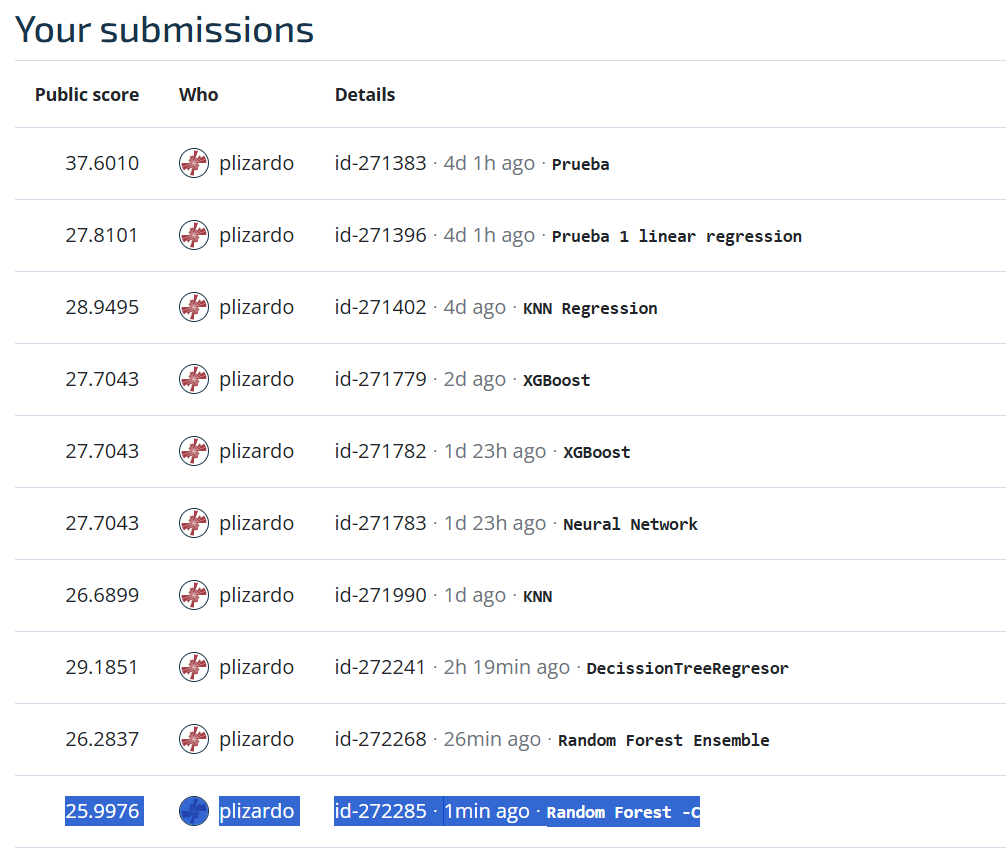

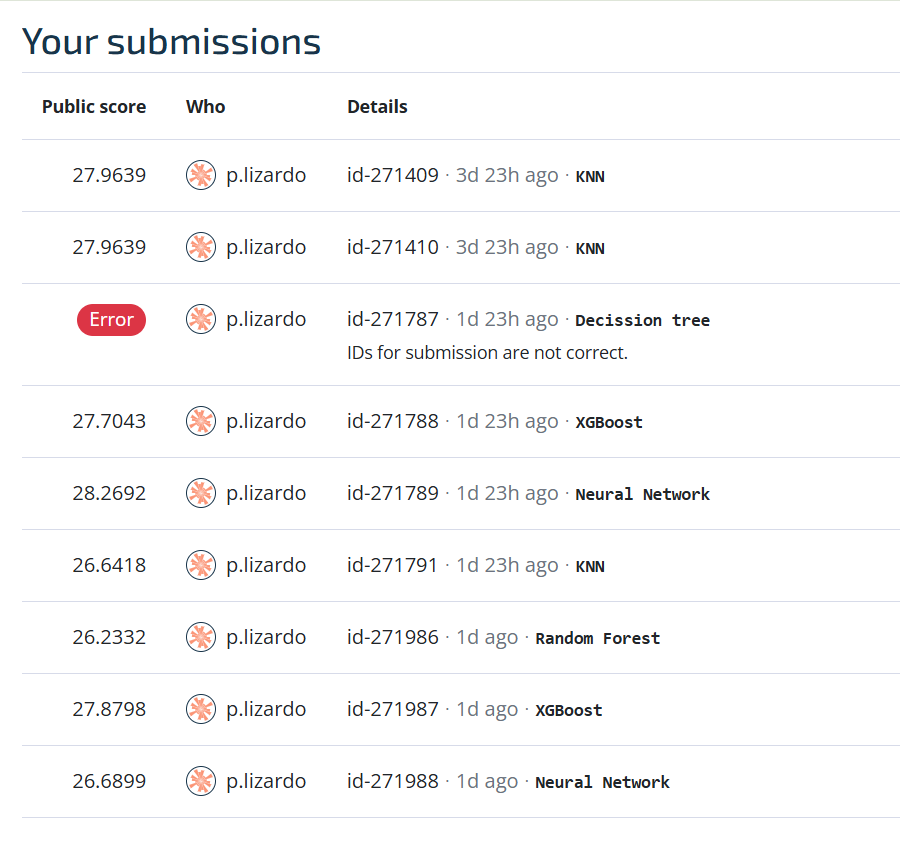